In [1]:
import os
import sys
import time
import re
from collections import namedtuple

import numpy as np
import torch
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision import transforms
from torchvision import models
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
def transform_net_load_image(filename, size=None, scale=None):
  """
  Load the image by the given filename. The image would be resized if size or scale is set. 

  :param size: New size of the image
  :param scale: The scale ratio to resize the image
  :return: The resized image
  """
  image = Image.open(filename).convert('RGB')
  target_size = image.size
  if size is not None:
    target_size = (size, size)
  elif scale is not None:
    target_size = (int(image.size[0] / scale), int(image.size[1] / scale))

  return image.resize(target_size, Image.ANTIALIAS)

def transform_net_imshow(image, title=None):
  # print(f'The size of the given image: {image.size()}')
  with torch.no_grad():
    image = image.cpu().clone().clamp(0, 255).numpy()
    image = image.transpose(1, 2, 0).astype('uint8')
    image = Image.fromarray(image)

  fig = plt.figure(figsize=(5,5))
  plt.imshow(image)
  if title is not None:
    plt.title(title)
  plt.xticks([])
  plt.yticks([])
  plt.show()

def transform_net_imshow_pair(original_image, output_image, original_title=None, output_title=None):
  with torch.no_grad():
    original_image = original_image.cpu().clone().clamp(0, 255).numpy()
    original_image = original_image.transpose(1, 2, 0).astype('uint8')
    original_image = Image.fromarray(original_image)

    output_image = output_image.cpu().clone().clamp(0, 255).numpy()
    output_image = output_image.transpose(1, 2, 0).astype('uint8')
    output_image = Image.fromarray(output_image)

  fig, ax = plt.subplots(1, 2, figsize = (10, 5))
  ax = ax.flatten()
  if original_title is not None:
    ax[0].set_title(original_title)
  ax[0].imshow(original_image)
  ax[0].set_axis_off()

  if output_title is not None:
    ax[1].set_title(output_title)
  ax[1].imshow(output_image)
  ax[1].set_axis_off()
  plt.show()

def gram_matrix(y):
  (b, ch, h, w) = y.size()
  features = y.view(b, ch, w * h)
  features_t = features.transpose(1, 2)
  gram = features.bmm(features_t) / (ch * h * w)
  return gram

def normalize_batch(batch):
  # normalize using imagenet mean and std
  mean = batch.new_tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
  std = batch.new_tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)
  batch = batch.div_(255.0)
  return (batch - mean) / std


class COCODataset(Dataset):
  def __init__(self, image_directory, transform=None):
    self.image_names = []
    self.image_directory = image_directory
    self.transform = transform
    for image_name in os.listdir(image_directory):
      self.image_names.append(image_name)

  def __len__(self):
    return len(self.image_names)

  def __getitem__(self, index):
    image_name = os.path.join(self.image_directory, self.image_names[index])
    image = transform_net_load_image(image_name)

    if self.transform:
      image = self.transform(image)

    return image, 0
  

In [3]:
# VGG-19 model for NST
class Vgg19(torch.nn.Module):
  def __init__(self, requires_grad=False):
    super(Vgg19, self).__init__()
    # use relu1_2, relu2_2, relu3_3, relu4_3 as mentioned in NST paper
    self.chosen_features = ['3', '8', '15', '24']

    # we don't need to run anything further than conv5_1 layer
    self.model = models.vgg19(pretrained=True).features[:25]

    if not requires_grad:
      for param in self.parameters():
        param.requires_grad = False

  def forward(self, x):
    # stores relevant features from output
    features = []

    # Go through each layer in model and store the output of the layer 
    # in features, if the layer is in the chosen_features. 
    # Return all the activations for the specific layers in chosen_features.
    for layer_num, layer in enumerate(self.model):
      x = layer(x)
      if str(layer_num) in self.chosen_features:
        features.append(x)

    vgg_outputs = namedtuple("vgg_outputs", ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3'])
    return vgg_outputs(features[0], features[1], features[2], features[3])
    # return features

In [ ]:
# class Vgg16(torch.nn.Module):
#   def __init__(self, requires_grad=False):
#     super(Vgg16, self).__init__()
#     vgg_pretrained_features = models.vgg16(pretrained=True).features
#     self.slice1 = torch.nn.Sequential()
#     self.slice2 = torch.nn.Sequential()
#     self.slice3 = torch.nn.Sequential()
#     self.slice4 = torch.nn.Sequential()
#     for x in range(4):
#       self.slice1.add_module(str(x), vgg_pretrained_features[x])
#     for x in range(4, 9):
#       self.slice2.add_module(str(x), vgg_pretrained_features[x])
#     for x in range(9, 16):
#       self.slice3.add_module(str(x), vgg_pretrained_features[x])
#     for x in range(16, 23):
#       self.slice4.add_module(str(x), vgg_pretrained_features[x])
    
#     if not requires_grad:
#       for param in self.parameters():
#         param.requires_grad = False

#   def forward(self, x):
#     x = self.slice1(x)
#     result_relu1_2 = x
#     x = self.slice2(x)
#     result_relu2_2 = x
#     x = self.slice3(x)
#     result_relu3_3 = x
#     x = self.slice4(x)
#     result_relu4_3 = x
#     vgg_outputs = namedtuple("vgg_outputs", ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3'])
#     return vgg_outputs(result_relu1_2, result_relu2_2, result_relu3_3, result_relu4_3)

In [4]:
class ConvLayer(torch.nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride):
    super(ConvLayer, self).__init__()
    reflection_padding = kernel_size // 2
    self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
    self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride)

  def forward(self, x):
    x = self.reflection_pad(x)
    x = self.conv2d(x)
    return x


class ResidualBlock(torch.nn.Module):
  def __init__(self, channels):
    super(ResidualBlock, self).__init__()
    self.conv1 = ConvLayer(channels, channels, kernel_size=3, stride=1)
    self.in1 = torch.nn.InstanceNorm2d(channels, affine=True)
    self.conv2 = ConvLayer(channels, channels, kernel_size=3, stride=1)
    self.in2 = torch.nn.InstanceNorm2d(channels, affine=True)
    self.relu = torch.nn.ReLU()

  def forward(self, x):
    residual = x
    x = self.relu(self.in1(self.conv1(x)))
    x = self.in2(self.conv2(x))
    x = x + residual
    return x


class UpsampleConvLayer(torch.nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride, upsample=None):
    super(UpsampleConvLayer, self).__init__()
    self.upsample = upsample
    reflection_padding = kernel_size // 2
    self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
    self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride)

  def forward(self, x):
    if self.upsample:
      x = torch.nn.functional.interpolate(x, mode='nearest', scale_factor=self.upsample)
    x = self.reflection_pad(x)
    return self.conv2d(x)


class BatchInstanceNorm2d(torch.nn.Module):
  def __init__(self, style_num, in_channels):
    super(BatchInstanceNorm2d, self).__init__()
    self.inns = torch.nn.ModuleList([torch.nn.InstanceNorm2d(in_channels, affine=True) for i in range(style_num)])

  def forward(self, x, style_id):
      out = torch.stack([self.inns[style_id[i]](x[i].unsqueeze(0)).squeeze_(0) for i in range(len(style_id))])
      return out


class TransformerNet(torch.nn.Module):
  def __init__(self, style_num):
    super(TransformerNet, self).__init__()
    self.conv1 = ConvLayer(3, 32, kernel_size=9, stride=1)
    self.in1 = BatchInstanceNorm2d(style_num, 32)
    self.conv2 = ConvLayer(32, 64, kernel_size=3, stride=2)
    self.in2 = BatchInstanceNorm2d(style_num, 64)
    self.conv3 = ConvLayer(64, 128, kernel_size=3, stride=2)
    self.in3 = BatchInstanceNorm2d(style_num, 128)
    # residual layers
    self.res1 = ResidualBlock(128)
    self.res2 = ResidualBlock(128)
    self.res3 = ResidualBlock(128)
    self.res4 = ResidualBlock(128)
    self.res5 = ResidualBlock(128)
    # upsampling layers
    self.deconv1 = UpsampleConvLayer(128, 64, kernel_size=3, stride=1, upsample=2)
    self.in4 = BatchInstanceNorm2d(style_num, 64)
    self.deconv2 = UpsampleConvLayer(64, 32, kernel_size=3, stride=1, upsample=2)
    self.in5 = BatchInstanceNorm2d(style_num, 32)
    self.deconv3 = ConvLayer(32, 3, kernel_size=9, stride=1)

    self.relu = torch.nn.ReLU()

  def forward(self, x, style_id):
    x = self.relu(self.in1(self.conv1(x), style_id))
    x = self.relu(self.in2(self.conv2(x), style_id))
    x = self.relu(self.in3(self.conv3(x), style_id))
    x = self.res1(x)
    x = self.res2(x)
    x = self.res3(x)
    x = self.res4(x)
    x = self.res5(x)
    x = self.relu(self.in4(self.deconv1(x), style_id))
    x = self.relu(self.in5(self.deconv2(x), style_id))
    return self.deconv3(x)

In [ ]:
!wget http://images.cocodataset.org/zips/train2017.zip

--2022-05-04 18:41:09--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.225.209
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.225.209|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G  47.3MB/s    in 6m 55s  

2022-05-04 18:48:05 (44.4 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]



In [ ]:
!unzip train2017.zip

Streaming output truncated to the last 5000 lines.
 extracting: train2017/000000259556.jpg  
 extracting: train2017/000000381931.jpg  
 extracting: train2017/000000569592.jpg  
 extracting: train2017/000000229396.jpg  
 extracting: train2017/000000488990.jpg  
 extracting: train2017/000000348684.jpg  
 extracting: train2017/000000234031.jpg  
 extracting: train2017/000000563584.jpg  
 extracting: train2017/000000276069.jpg  
 extracting: train2017/000000401194.jpg  
 extracting: train2017/000000502089.jpg  
 extracting: train2017/000000192183.jpg  
 extracting: train2017/000000425127.jpg  
 extracting: train2017/000000126766.jpg  
 extracting: train2017/000000324161.jpg  
 extracting: train2017/000000452746.jpg  
 extracting: train2017/000000423782.jpg  
 extracting: train2017/000000546343.jpg  
 extracting: train2017/000000249290.jpg  
 extracting: train2017/000000025529.jpg  
 extracting: train2017/000000316928.jpg  
 extracting: train2017/000000337866.jpg  
 extracting: train2017/00

In [ ]:
!ls

drive  image  sample_data  train2017  train2017.zip


In [ ]:
!ls train2017

Streaming output truncated to the last 5000 lines.
000000120642.jpg  000000267048.jpg  000000411215.jpg  000000557783.jpg
000000120643.jpg  000000267049.jpg  000000411223.jpg  000000557785.jpg
000000120644.jpg  000000267055.jpg  000000411225.jpg  000000557794.jpg
000000120645.jpg  000000267059.jpg  000000411226.jpg  000000557804.jpg
000000120648.jpg  000000267064.jpg  000000411238.jpg  000000557811.jpg
000000120655.jpg  000000267067.jpg  000000411241.jpg  000000557812.jpg
000000120666.jpg  000000267068.jpg  000000411243.jpg  000000557819.jpg
000000120670.jpg  000000267076.jpg  000000411247.jpg  000000557823.jpg
000000120674.jpg  000000267082.jpg  000000411253.jpg  000000557824.jpg
000000120676.jpg  000000267088.jpg  000000411257.jpg  000000557825.jpg
000000120682.jpg  000000267095.jpg  000000411261.jpg  000000557829.jpg
000000120683.jpg  000000267105.jpg  000000411263.jpg  000000557830.jpg
000000120697.jpg  000000267106.jpg  000000411266.jpg  000000557832.jpg
000000120703.jpg  00000026

In [ ]:
from google.colab import drive
drive.mount('./drive')

Mounted at ./drive


In [5]:
# set device to gpu or cpu based on availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def train(style_folder_path="image/", 
          dataset_path="./train2017", 
          image_size=256,
          style_size=512, 
          epoch_size=2,
          batch_size=4, 
          learning_rate=1e-3,
          content_weight=1e5,
          style_weight=1e10
          ):
  # load the training data
  data_transform = transforms.Compose([
                                     transforms.Resize(image_size),
                                     transforms.CenterCrop(image_size),
                                     transforms.ToTensor(),
                                     transforms.Lambda(lambda x: x.mul(255))
  ])
  train_dataset = COCODataset(dataset_path, data_transform)
  train_loader = DataLoader(train_dataset, batch_size=batch_size)

  # load style images to train
  style_image_names = [f for f in os.listdir(style_folder_path)]
  style_num = len(style_image_names)

  # initialize the transformer net
  transformer_net = TransformerNet(style_num=style_num).to(device)
  optimizer = Adam(transformer_net.parameters(), learning_rate)
  mse_loss = torch.nn.MSELoss()

  vgg = Vgg19().to(device)
  style_transform = transforms.Compose([
                                        transforms.Resize(style_size),
                                        transforms.CenterCrop(style_size),
                                        transforms.ToTensor(),
                                        transforms.Lambda(lambda x: x.mul(255))
  ])

  style_batch = []
  for i in range(style_num):
    style_image = transform_net_load_image(style_folder_path + style_image_names[i], size=style_size)
    style_image = style_transform(style_image)
    style_batch.append(style_image)

  style_image = torch.stack(style_batch).to(device)

  # extract the features from the style image
  style_image_vgg_output = vgg(normalize_batch(style_image))
  style_features = [gram_matrix(y) for y in style_image_vgg_output]

  # statistics
  content_loss_list = []
  style_loss_list = []
  image_count_index = []
  total_image_count = 0
  epoch_start = 0

  # Load pre-trained model
  path = './drive/MyDrive/checkpoints/model.pth'
  checkpoint = torch.load(path)
  transformer_net.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  content_loss_list = checkpoint['content_loss']
  style_loss_list = checkpoint['style_loss']
  image_count_index = checkpoint['count_index']
  total_image_count = image_count_index[-1]
  epoch_start = checkpoint['epoch']

  for epoch in range(epoch_start, epoch_size):
    transformer_net.train()
    average_content_loss = 0.
    average_style_loss = 0.
    image_count = 0

    for batch_id, (x, _) in enumerate(train_loader):
      cur_batch_size = len(x)

      if cur_batch_size < batch_size:
          break # skip to next epoch when no enough images left in the last batch of current epoch
      image_count += cur_batch_size
      total_image_count += cur_batch_size
      optimizer.zero_grad()

      batch_style_id = [i % style_num for i in range(image_count-cur_batch_size, image_count)]
      x = x.to(device)
      original_image = x.cpu().clone()
      output_image = transformer_net(x, style_id=batch_style_id)
      original_output_image = output_image.cpu().clone()
      output_image = normalize_batch(output_image)
      x = normalize_batch(x)

      output_image_vgg_outputs = vgg(output_image)
      features_x = vgg(x)

      # get the content loss
      content_loss = content_weight * mse_loss(output_image_vgg_outputs.relu3_3, features_x.relu3_3)

      # get the style loss
      style_loss = 0.
      for output_image_vgg_output, style_feature in zip(output_image_vgg_outputs, style_features):
        output_image_style_feature = gram_matrix(output_image_vgg_output)
        style_loss += mse_loss(output_image_style_feature, style_feature[:batch_size, :, :])
      style_loss *= style_weight

      # run the optimization
      total_loss = content_loss + style_loss
      total_loss.backward()
      optimizer.step()

      # calculate the statistic
      average_content_loss += content_loss.item()
      average_style_loss += style_loss.item()

      if (batch_id + 1) % 1000 == 0:
        print(f'Epoch {epoch}:\t[{image_count}/{len(train_dataset)}]\taverage content loss: {average_content_loss / (batch_id + 1)}\taverage style loss: {average_style_loss / (batch_id + 1)}\ttotal loss: {(average_content_loss + average_style_loss) / (batch_id + 1)}')
        for i in range(len(original_output_image)):
          transform_net_imshow_pair(original_image[i], original_output_image[i], 'Content Image: ' + str(i+1), 'Output Image: ' + str(i+1))

        content_loss_list.append(content_loss.item())
        style_loss_list.append(style_loss.item())
        image_count_index.append(total_image_count)

        # saves the model checkpoint
        path = './drive/MyDrive/checkpoints/model.pth'
        torch.save({
            'epoch': epoch,
            'model_state_dict': transformer_net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'content_loss': content_loss_list,
            'style_loss': style_loss_list,
            'count_index': image_count_index
            }, path)
    
    path = './drive/MyDrive/checkpoints/model.pth'
    torch.save({
        'epoch': epoch,
        'model_state_dict': transformer_net.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'content_loss': content_loss_list,
        'style_loss': style_loss_list,
        'count_index': image_count_index
        }, path)

  plt.plot(image_count_index, content_loss_list)
  plt.plot(image_count_index, style_loss_list)
  plt.legend(['content loss', 'style loss'])
  plt.xlabel('Number of training images seen')
  plt.ylabel('Loss')
  plt.title('Model Loss')
  print(image_count_index)
  plt.show()


In [ ]:
train()

In [ ]:
train() # 2nd epoch

In [ ]:
train() # 1st epoch

[4000, 8000, 12000, 16000, 20000, 24000, 28000, 32000, 36000, 40000, 44000, 48000, 52000, 56000, 60000, 64000, 68000, 72000, 76000, 80000, 84000, 88000, 92000, 96000, 100000, 104000, 108000, 112000, 116000, 120000, 124000, 128000, 132000, 136000, 140000, 144000, 148000, 152000, 156000, 160000, 164000, 168000, 172000, 176000, 180000, 184000, 188000, 192000, 196000, 200000, 204000, 208000, 212000, 216000, 220000, 224000, 228000, 232000]


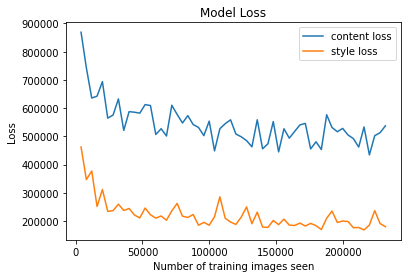

In [ ]:
# loss plot generated train()

# 新段落

In [6]:
def get_transformer_net_model(model_path, style_num):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = TransformerNet(style_num=style_num)
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()

    return model

In [10]:
def save_image(filename, data):
    img = data.clone().clamp(0, 255).numpy()
    img = img.transpose(1, 2, 0).astype("uint8")
    img = Image.fromarray(img)
    img.save(filename)

In [7]:
import torch
from torchvision import transforms


def stylize(image, model, input_style_id):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    content_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
    ])

    image = content_transform(image)
    image = image.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image, style_id=[input_style_id]).cpu()
    transform_net_imshow(output[0], 'style' + str(input_style_id))
    save_image('./output/' +'_style'+str(input_style_id)+'.jpg', output[0])

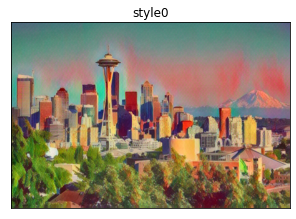

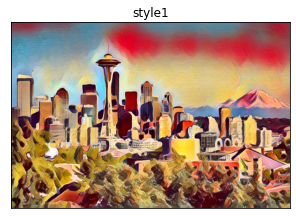

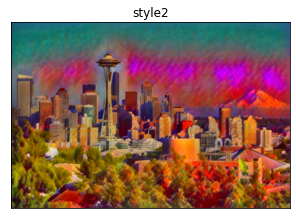

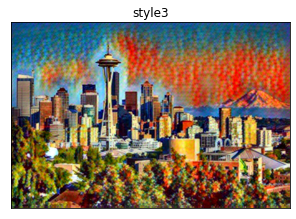

In [12]:
style_num = 4
model_path = './eval/model.pth'
output_path = './output/'
ratio_array = [0.25, 0.25, 0.25, 0.25]
transformer_net = TransformerNet(style_num=style_num).to(device)
checkpoint = torch.load(model_path)
transformer_net.load_state_dict(checkpoint['model_state_dict'])
content_image = transform_net_load_image('./eval/test.jpeg')
for i in range(style_num):
  stylize(content_image, transformer_net, i)


